In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load the dataset
df = pd.read_csv('exams.csv')
print(df.to_string)

# Grading function based on the grade
def assign_grade(score):
    if 97 <= score <= 100:
        return 'A'
    elif 93 <= score <= 96:
        return 'B+'
    elif 89 <= score <= 92:
        return 'B'
    elif 85 <= score <= 88:
        return 'C+'
    elif 81 <= score <= 84:
        return 'C'
    elif 77 <= score <= 80:
        return 'D+'
    elif 73 <= score <= 76:
        return 'D'
    else:
        return 'F'

# Assign grades to each subject
df['math_grade'] = df['math score'].apply(assign_grade)
df['reading_grade'] = df['reading score'].apply(assign_grade)
df['writing_grade'] = df['writing score'].apply(assign_grade)

# Calculate average score and assign final grade
df['average_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)
df['grade'] = df['average_score'].apply(assign_grade)


<bound method DataFrame.to_string of      gender race/ethnicity parental level of education         lunch  \
0      male        group A                 high school      standard   
1    female        group D            some high school  free/reduced   
2      male        group E                some college  free/reduced   
3      male        group B                 high school      standard   
4      male        group E          associate's degree      standard   
..      ...            ...                         ...           ...   
995    male        group C                 high school      standard   
996    male        group D          associate's degree  free/reduced   
997  female        group C            some high school  free/reduced   
998  female        group C                some college      standard   
999    male        group A                some college      standard   

    test preparation course  math score  reading score  writing score  
0                 complete

In [ ]:
def process_subject(subject):
    print(f"\nProcessing {subject}...")

    # Prepare features and target
    X = df.drop(columns=[f'{subject}_grade'])
    X = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical features
    y = df[f'{subject}_grade']

    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split 70% training, 20% testing, 10% unseen
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_test, X_unseen, y_test, y_unseen = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_unseen_scaled = scaler.transform(X_unseen)

    # Train SVM with cross-validation
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42, probability=True)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cross_val_acc = cross_val_score(svm_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation Accuracy (Mean) for {subject}: {np.mean(cross_val_acc):.4f}")

    # Train final model
    svm_model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_test_pred = svm_model.predict(X_test_scaled)
    y_test_proba = svm_model.predict_proba(X_test_scaled)

    # Test set evaluation
    print(f"\n{subject} Test Evaluation:")
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_test_pred, average='weighted'))
    print("ROC-AUC:", roc_auc_score(y_test, y_test_proba, multi_class='ovr'))

    # Confusion matrix for test set
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Greens')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {subject} Test Set")
    plt.show()

    # Predict on unseen data
    y_unseen_pred = svm_model.predict(X_unseen_scaled)
    y_unseen_proba = svm_model.predict_proba(X_unseen_scaled)

    # Unseen data evaluation
    print(f"\n{subject} Unseen Data Evaluation:")
    print("Unseen Accuracy:", accuracy_score(y_unseen, y_unseen_pred))
    print("Classification Report:\n", classification_report(y_unseen, y_unseen_pred))
    print("Unseen Precision:", precision_score(y_unseen, y_unseen_pred, average='weighted'))
    print("Unseen Recall:", recall_score(y_unseen, y_unseen_pred, average='weighted'))
    print("Unseen ROC-AUC:", roc_auc_score(y_unseen, y_unseen_proba, multi_class='ovr'))

    # Confusion matrix for unseen data
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_unseen, y_unseen_pred), annot=True, fmt='d', cmap='Oranges')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {subject} Unseen Data")
    plt.show()



Processing math...
Cross-validation Accuracy (Mean) for math: 0.6414

math Test Evaluation:
Test Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.38      0.43      0.40         7
           2       0.50      0.33      0.40         3
           3       0.33      0.38      0.36        13
           4       0.22      0.40      0.29        10
           5       0.28      0.65      0.39        17
           6       0.23      0.18      0.20        17
           7       0.99      0.77      0.86       128

    accuracy                           0.64       200
   macro avg       0.44      0.47      0.44       200
weighted avg       0.74      0.64      0.67       200

Precision: 0.7449285159285159
Recall: 0.64
ROC-AUC: 0.9264531786369065


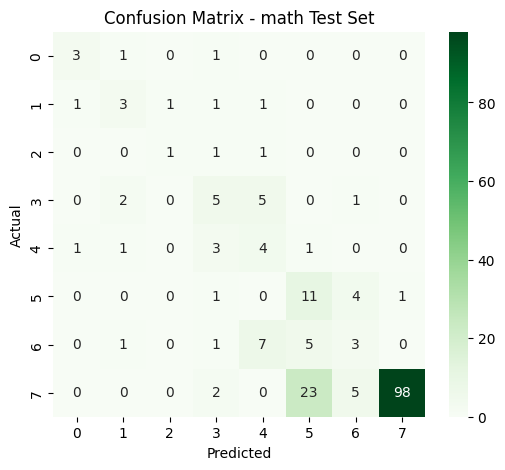


math Unseen Data Evaluation:
Unseen Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.50      0.25      0.33         4
           2       1.00      0.50      0.67         2
           3       0.10      0.17      0.12         6
           4       0.20      0.40      0.27         5
           5       0.25      0.44      0.32         9
           6       0.14      0.11      0.12         9
           7       0.98      0.79      0.88        63

    accuracy                           0.62       100
   macro avg       0.48      0.46      0.44       100
weighted avg       0.72      0.62      0.66       100

Unseen Precision: 0.7223375350140057
Unseen Recall: 0.62
Unseen ROC-AUC: 0.9355033764968113


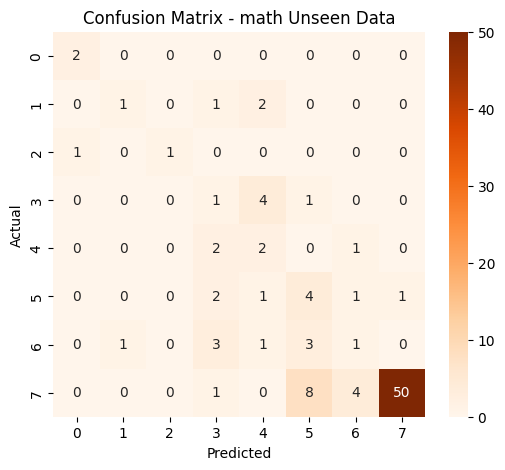


Processing reading...
Cross-validation Accuracy (Mean) for reading: 0.6343

reading Test Evaluation:
Test Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.38      0.43      0.40         7
           2       0.75      0.60      0.67         5
           3       0.37      0.50      0.42        14
           4       0.47      0.50      0.48        14
           5       0.39      0.67      0.49        21
           6       0.47      0.39      0.42        18
           7       1.00      0.84      0.91       116

    accuracy                           0.71       200
   macro avg       0.56      0.59      0.57       200
weighted avg       0.77      0.71      0.73       200

Precision: 0.7698311403508771
Recall: 0.71
ROC-AUC: 0.9516179489382668


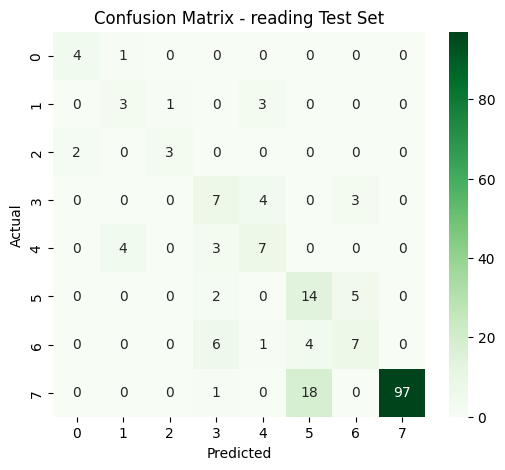


reading Unseen Data Evaluation:
Unseen Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         3
           2       0.50      0.50      0.50         2
           3       0.64      0.88      0.74         8
           4       0.71      0.71      0.71         7
           5       0.35      0.80      0.48        10
           6       0.50      0.33      0.40         9
           7       1.00      0.79      0.88        58

    accuracy                           0.73       100
   macro avg       0.56      0.63      0.57       100
weighted avg       0.79      0.73      0.74       100

Unseen Precision: 0.7931916996047431
Unseen Recall: 0.73
Unseen ROC-AUC: 0.9469396514283793


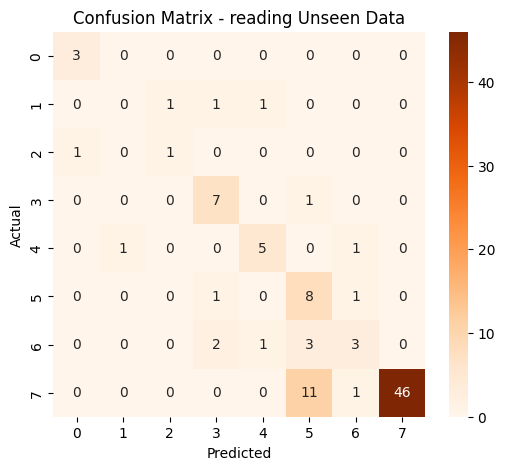


Processing writing...
Cross-validation Accuracy (Mean) for writing: 0.7057

writing Test Evaluation:
Test Accuracy: 0.725
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.36      0.44      0.40         9
           2       0.50      0.40      0.44         5
           3       0.38      0.40      0.39        15
           4       0.50      0.18      0.27        11
           5       0.37      0.65      0.47        17
           6       0.29      0.36      0.32        14
           7       0.98      0.90      0.94       123

    accuracy                           0.72       200
   macro avg       0.52      0.50      0.49       200
weighted avg       0.76      0.72      0.74       200

Precision: 0.7643585825722083
Recall: 0.725
ROC-AUC: 0.94046650609492


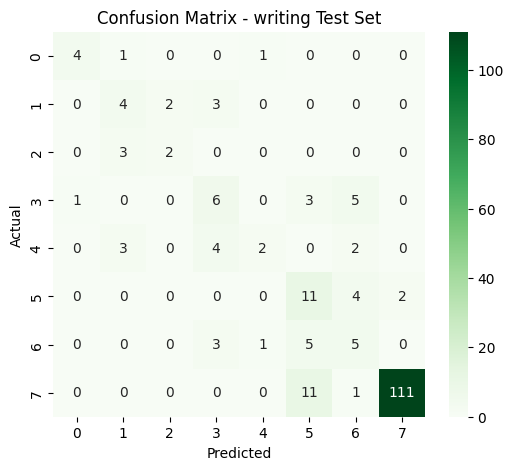


writing Unseen Data Evaluation:
Unseen Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.60      0.75      0.67         4
           2       1.00      0.67      0.80         3
           3       0.67      0.57      0.62         7
           4       0.20      0.20      0.20         5
           5       0.55      0.67      0.60         9
           6       0.50      0.71      0.59         7
           7       0.98      0.94      0.96        62

    accuracy                           0.81       100
   macro avg       0.69      0.65      0.65       100
weighted avg       0.83      0.81      0.82       100

Unseen Precision: 0.8342491011813046
Unseen Recall: 0.81
Unseen ROC-AUC: 0.9540632534419345


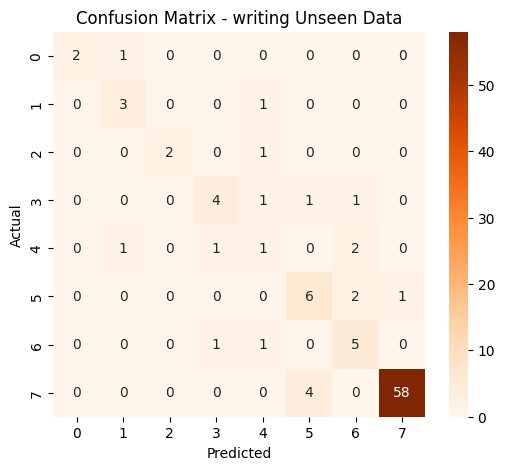

In [ ]:
# Process each subject separately
for subject in ['math', 'reading', 'writing']:
    process_subject(subject)
